## Inspect the dataset 

In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

# --- Inspecting the msstnetdataset ---
BASE_MSSTNET_PATH = Path('/kaggle/input/msstnetdataset/data/') # Adjust if the 'data' folder is not directly under msstnetdataset

print(f"Inspecting dataset at: {BASE_MSSTNET_PATH}")

if not BASE_MSSTNET_PATH.exists():
    print(f"ERROR: Path {BASE_MSSTNET_PATH} does not exist. Please check your Kaggle input path.")
else:
    print("\nTop-level stream folders:")
    for stream_folder in BASE_MSSTNET_PATH.iterdir():
        if stream_folder.is_dir():
            print(f"- {stream_folder.name}")
            for split_folder in stream_folder.iterdir():
                if split_folder.is_dir() and split_folder.name in ['train', 'val']:
                    print(f"  - {split_folder.name}")
                    npy_files = list(split_folder.glob('*.npy'))
                    print(f"    - Found {len(npy_files)} .npy files.")
                    if npy_files:
                        print(f"    - Example files: {[f.name for f in npy_files[:3]]}")
                        try:
                            sample_npy_path = npy_files[0]
                            sample_data = np.load(sample_npy_path)
                            print(f"    - Shape of {sample_npy_path.name}: {sample_data.shape}")
                        except Exception as e:
                            print(f"    - Could not load or get shape of {sample_npy_path.name}: {e}")
                    print("-" * 20)

# --- Inspecting the accompanying CSV label files ---
CSV_PATH_ROOT = Path('/kaggle/input/msstnetdataset/') 

train_csv_path = CSV_PATH_ROOT / 'Train.csv'
val_csv_path = CSV_PATH_ROOT / 'Validation.csv'

print("\nChecking for CSV label files:")
if train_csv_path.exists():
    print(f"\nFound Train CSV: {train_csv_path}")
    try:
        df_train = pd.read_csv(train_csv_path)
        print("Train CSV Head:")
        print(df_train.head())
        print(f"Train CSV Info:")
        df_train.info()
        if 'label' in df_train.columns:
            print("Unique labels in Train CSV:", df_train['label'].nunique())
            print("Example labels:", df_train['label'].unique()[:10])
        if 'video_id' in df_train.columns: 
             print("Video ID column exists.")
    except Exception as e:
        print(f"Could not read Train CSV: {e}")
else:
    print(f"Train CSV ({train_csv_path}) not found at this location.")

if val_csv_path.exists():
    print(f"\nFound Validation CSV: {val_csv_path}")
    try:
        df_val = pd.read_csv(val_csv_path)
        print("Validation CSV Head:")
        print(df_val.head())
    except Exception as e:
        print(f"Could not read Validation CSV: {e}")
else:
    print(f"Validation CSV ({val_csv_path}) not found at this location.")

# --- Inspecting current data structure (/kaggle/input/train-jester-kp/) ---
YOUR_CURRENT_DATA_PATH = Path('/kaggle/input/train-jester-kp/train_data/')
print(f"\nInspecting your current data path: {YOUR_CURRENT_DATA_PATH}")
if YOUR_CURRENT_DATA_PATH.exists():
    video_id_folders = list(YOUR_CURRENT_DATA_PATH.glob('*')) 
    print(f"Found {len(video_id_folders)} entries (expected video_id folders).")
    if video_id_folders:
        example_video_folder = video_id_folders[0]
        if example_video_folder.is_dir():
            print(f"Example video_id folder: {example_video_folder.name}")
            frame_npy_files = list(example_video_folder.glob('*.npy'))
            print(f"  Found {len(frame_npy_files)} frame .npy files in {example_video_folder.name}.")
            if frame_npy_files:
                example_frame_path = frame_npy_files[0]
                try:
                    frame_data = np.load(example_frame_path)
                    print(f"  Shape of example frame {example_frame_path.name}: {frame_data.shape}") 
                except Exception as e:
                    print(f"  Could not load frame {example_frame_path.name}: {e}")
else:
    print(f"ERROR: Your current data path {YOUR_CURRENT_DATA_PATH} does not exist.")

Inspecting dataset at: /kaggle/input/msstnetdataset/data

Top-level stream folders:
- bone_stream
  - val
    - Found 4780 .npy files.
    - Example files: ['135849.npy', '117851.npy', '29479.npy']
    - Shape of 135849.npy: (37, 47, 3)
--------------------
  - train
    - Found 33980 .npy files.
    - Example files: ['130848.npy', '42378.npy', '63183.npy']
    - Shape of 130848.npy: (37, 47, 3)
--------------------
- bone_motion_stream
  - val
    - Found 4780 .npy files.
    - Example files: ['135849.npy', '117851.npy', '29479.npy']
    - Shape of 135849.npy: (36, 47, 3)
--------------------
  - train
    - Found 33980 .npy files.
    - Example files: ['130848.npy', '42378.npy', '63183.npy']
    - Shape of 130848.npy: (36, 47, 3)
--------------------
- joint_motion_stream
  - val
    - Found 4780 .npy files.
    - Example files: ['135849.npy', '117851.npy', '29479.npy']
    - Shape of 135849.npy: (36, 48, 3)
--------------------
  - train
    - Found 33980 .npy files.
    - Example f

## 1. Project Setup and Parameters

In [ ]:
print("--- 1. Project Setup and Parameters ---")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import datetime


# Dataset parameters
BASE_DATA_PATH = Path('/kaggle/input/msstnetdataset/data/joint_stream/') # Using joint_stream
TRAIN_NPY_PATH = BASE_DATA_PATH / 'train'
VAL_NPY_PATH = BASE_DATA_PATH / 'val'

TRAIN_CSV_PATH = Path('/kaggle/input/jester-labels/Train.csv')
VAL_CSV_PATH = Path('/kaggle/input/jester-labels/Validation.csv')

ACTIONS = [
    "Doing other things", "No gesture", 'Rolling Hand Backward', 'Rolling Hand Forward', 'Shaking Hand',
    'Sliding Two Fingers Down', 'Sliding Two Fingers Left', 'Sliding Two Fingers Right', 'Sliding Two Fingers Up',
    'Stop Sign', 'Swiping Down','Swiping Left', 'Swiping Right', 'Swiping Up',
    'Thumb Down', 'Thumb Up',
    'Turning Hand Clockwise', 'Turning Hand Counterclockwise'
]
NUM_CLASSES = len(ACTIONS)

# Model / Data shape parameters
MAX_FRAMES = 37
NUM_KEYPOINTS = 48
NUM_COORDINATES = 3

# Training parameters
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001


--- 1. Project Setup and Parameters ---


2025-05-28 08:04:45.192978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748419485.622305      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748419485.736438      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


---
## 2. Data Loading and Preprocessing

This function will load the pre-shaped `.npy` files from `joint_stream` and use a CSV for labels.

In [ ]:
print("\n--- 2. Data Loading and Preprocessing ---")

def create_tf_dataset_from_npy_and_csv(npy_folder_path, csv_label_path, actions_list,
                                       max_frames, num_keypoints, num_coordinates,
                                       batch_size, num_classes):
    print(f"Loading labels from: {csv_label_path}")
    if not csv_label_path.exists():
        raise FileNotFoundError(f"Label file not found: {csv_label_path}")
    df_labels = pd.read_csv(csv_label_path)

    if 'video_id' not in df_labels.columns or 'label' not in df_labels.columns:
        raise ValueError("CSV must contain 'video_id' and 'label' columns. Found: " + str(df_labels.columns))

    df_labels = df_labels[df_labels['label'].isin(actions_list)]
    if df_labels.empty:
        raise ValueError(f"No relevant labels found in {csv_label_path} for the specified ACTIONS.")

    unique_sorted_actions_in_csv = sorted(list(df_labels['label'].unique()))
    action_to_id = {action: i for i, action in enumerate(unique_sorted_actions_in_csv)}
    
    strict_action_to_id = {action: i for i, action in enumerate(actions_list)}
    df_labels['label_id'] = df_labels['label'].map(strict_action_to_id)
    df_labels.dropna(subset=['label_id'], inplace=True) 
    df_labels['label_id'] = df_labels['label_id'].astype(int)


    print(f"Found {len(df_labels)} samples in CSV after filtering.")

    video_files_in_folder = {f.stem for f in npy_folder_path.glob('*.npy')} 
    
    valid_video_ids = []
    numeric_labels = []

    for index, row in df_labels.iterrows():
        video_id_str = str(row['video_id']) 
        if video_id_str in video_files_in_folder:
            valid_video_ids.append(video_id_str)
            numeric_labels.append(row['label_id'])

    if not valid_video_ids:
        raise ValueError(f"No matching video IDs found between CSV and NPY folder: {npy_folder_path}")
    
    print(f"Found {len(valid_video_ids)} matching video samples between CSV and NPY folder.")

    num_samples = len(valid_video_ids)
    x_data = np.zeros((num_samples, max_frames, num_keypoints, num_coordinates), dtype=np.float32)
    y_labels = np.array(numeric_labels, dtype=np.int32)

    print(f"Loading NPY data from {npy_folder_path}...")
    for i, video_id_stem in enumerate(tqdm(valid_video_ids)):
        npy_file_path = npy_folder_path / f"{video_id_stem}.npy"
        try:
            data = np.load(npy_file_path)
            if data.shape[0] == max_frames and data.shape[1] == num_keypoints and data.shape[2] == num_coordinates:
                 x_data[i] = data
            elif data.shape[0] < max_frames: 
                padded_data = np.zeros((max_frames, num_keypoints, num_coordinates), dtype=np.float32)
                padded_data[:data.shape[0]] = data
                if data.shape[0] > 0: 
                    padded_data[data.shape[0]:] = data[-1]
                x_data[i] = padded_data
            else: 
                x_data[i] = data[:max_frames]

        except Exception as e:
            print(f"Error loading or processing {npy_file_path}: {e}")
            x_data[i] = np.zeros((max_frames, num_keypoints, num_coordinates), dtype=np.float32)


    dataset = tf.data.Dataset.from_tensor_slices((x_data, tf.keras.utils.to_categorical(y_labels, num_classes=num_classes)))
    dataset = dataset.shuffle(buffer_size=len(x_data)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Check if label files exist before creating dataset
if not TRAIN_CSV_PATH.exists() or not VAL_CSV_PATH.exists():
    print("***************************************************************************")
    print("ERROR: Train.csv or Validation.csv not found at the expected locations:")
    print(f"Expected Train CSV: {TRAIN_CSV_PATH}")
    print(f"Expected Validation CSV: {VAL_CSV_PATH}")
    print("Please ensure these files exist and the paths are correct before proceeding.")
    print("The notebook will likely fail if these files are missing.")
    print("***************************************************************************")
    train_dataset = None
    val_dataset = None
else:
    train_dataset = create_tf_dataset_from_npy_and_csv(
        TRAIN_NPY_PATH, TRAIN_CSV_PATH, ACTIONS,
        MAX_FRAMES, NUM_KEYPOINTS, NUM_COORDINATES, BATCH_SIZE, NUM_CLASSES
    )
    val_dataset = create_tf_dataset_from_npy_and_csv(
        VAL_NPY_PATH, VAL_CSV_PATH, ACTIONS,
        MAX_FRAMES, NUM_KEYPOINTS, NUM_COORDINATES, BATCH_SIZE, NUM_CLASSES
    )

    if train_dataset:
        for data_batch, label_batch in train_dataset.take(1):
            print("Train Data batch shape:", data_batch.shape)
            print("Train Labels batch shape:", label_batch.shape)
    if val_dataset:
        for data_batch, label_batch in val_dataset.take(1):
            print("Validation Data batch shape:", data_batch.shape)
            print("Validation Labels batch shape:", label_batch.shape)


--- 2. Data Loading and Preprocessing ---
Loading labels from: /kaggle/input/jester-labels/Train.csv
Found 33980 samples in CSV after filtering.
Found 33980 matching video samples between CSV and NPY folder.
Loading NPY data from /kaggle/input/msstnetdataset/data/joint_stream/train...


100%|██████████| 33980/33980 [04:57<00:00, 114.17it/s]
I0000 00:00:1748419804.171860      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748419804.172574      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Loading labels from: /kaggle/input/jester-labels/Validation.csv
Found 4780 samples in CSV after filtering.
Found 4473 matching video samples between CSV and NPY folder.
Loading NPY data from /kaggle/input/msstnetdataset/data/joint_stream/val...


100%|██████████| 4473/4473 [00:37<00:00, 119.98it/s]


Train Data batch shape: (32, 37, 48, 3)
Train Labels batch shape: (32, 18)
Validation Data batch shape: (32, 37, 48, 3)
Validation Labels batch shape: (32, 18)


---
## 3. Shift-GCN Layers Implementation (Keras Custom Layers)

We'll implement the Non-Local Spatial Shift and Naive Temporal Shift operations.

### 3.1. Non-Local Spatial Shift Graph Convolution Layer

This layer will perform the non-local spatial shift on the keypoint dimension (`N`) and then apply a point-wise convolution. The shift operation is described as: for the $c^{th}$ input channel, its value at node $n$, $\tilde{F}_{n,c}$, is taken from $F_{(n - (c \pmod N)) \pmod N, c}$. This effectively means each channel is shifted differently along the node axis.

In [ ]:
class NonLocalSpatialShift(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        B, T, N, C_in = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3]
        
        num_channels_static = inputs.shape[-1]
        if num_channels_static is None: 
            num_channels_static = C_in 

        shifted_features_list = []
        for c_idx in range(num_channels_static):
            shift_val = tf.cast(c_idx % N, dtype=tf.int32)
            rolled_channel = tf.roll(inputs[:, :, :, c_idx], shift=shift_val, axis=2)
            shifted_features_list.append(tf.expand_dims(rolled_channel, axis=-1))

        shifted_inputs = tf.concat(shifted_features_list, axis=-1)
        return shifted_inputs

class SpatialShiftConvBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.spatial_shift = NonLocalSpatialShift()
        self.pw_conv = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', data_format='channels_last')
        self.bn = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, inputs, training=False):
        x = self.spatial_shift(inputs)
        x = self.pw_conv(x)
        x = self.bn(x, training=training)
        x = self.relu(x)
        return x

### 3.2. Naive Temporal Shift Graph Convolution Layer

This layer shifts channel groups temporally and applies a point-wise convolution.

In [ ]:
class NaiveTemporalShift(layers.Layer):
    def __init__(self, u=1, **kwargs):
        super().__init__(**kwargs)
        self.u = u
        self.num_partitions = 2 * u + 1

    def call(self, inputs):
        B, T, N, C_in = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3]
        
        num_channels_static = inputs.shape[-1]
        if num_channels_static is None:
             num_channels_static = C_in

        base_split_size = num_channels_static // self.num_partitions
        remainder = num_channels_static % self.num_partitions
        size_splits = [base_split_size + 1] * remainder + [base_split_size] * (self.num_partitions - remainder)
        
        size_splits = [s for s in size_splits if s > 0]
        actual_num_partitions = len(size_splits) 

        if actual_num_partitions == 0 : 
            return inputs

        channel_partitions = tf.split(inputs, num_or_size_splits=size_splits, axis=-1)
        
        shifted_partitions = []
        if actual_num_partitions == 1:
             return inputs
        
        for i in range(actual_num_partitions):
            if actual_num_partitions % 2 == 1: 
                current_u = (actual_num_partitions -1) // 2
                shift_val = i - current_u
            else: 
                shift_val = i - self.u
                if i >= actual_num_partitions // 2 and self.u > (actual_num_partitions // 2 -1) : 
                    shift_val = i - (actual_num_partitions // 2 -1)


            partition = channel_partitions[i]
            rolled_partition = partition
            
            if shift_val > 0:
                core = partition[:, :-shift_val, :, :]
                padding = tf.zeros_like(partition[:, :shift_val, :, :])
                rolled_partition = tf.concat([padding, core], axis=1)
            elif shift_val < 0:
                s_abs = -shift_val
                core = partition[:, s_abs:, :, :]
                padding = tf.zeros_like(partition[:, :s_abs, :, :])
                rolled_partition = tf.concat([core, padding], axis=1)
            
            shifted_partitions.append(rolled_partition)

        if not shifted_partitions:
            return inputs
            
        shifted_inputs = tf.concat(shifted_partitions, axis=-1)
        return shifted_inputs


class TemporalShiftConvBlock(layers.Layer):
    def __init__(self, filters, u=1, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.u = u
        self.temporal_shift = NaiveTemporalShift(u=self.u)
        self.pw_conv = layers.Conv2D(filters, kernel_size=(1,1), padding='same', data_format='channels_last')
        self.bn = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, inputs, training=False):
        x = self.temporal_shift(inputs)
        x = self.pw_conv(x)
        x = self.bn(x, training=training)
        x = self.relu(x)
        return x

### 3.3. Shift-GCN Block

A Shift-GCN block will consist of a spatial sub-block and a temporal sub-block. The paper's ST-GCN backbone uses residual blocks.

In [ ]:
class ShiftGCNBlock(layers.Layer):
    def __init__(self, filters_out, u_temporal=1, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.filters_out = filters_out
        self.spatial_block = SpatialShiftConvBlock(filters_out)
        self.temporal_block = TemporalShiftConvBlock(filters_out, u=u_temporal)
        self.residual_conv = None 

    def build(self, input_shape):
        # input_shape: (batch, T, N, C_in)
        filters_in = input_shape[-1]
        if filters_in != self.filters_out:
            self.residual_conv = layers.Conv2D(
                self.filters_out, kernel_size=(1,1), padding='same', name=f"{self.name}_res_proj" if self.name else None
            )
        super().build(input_shape)


    def call(self, inputs, training=False):
        residual = inputs
        
        x = self.spatial_block(inputs, training=training)
        x = self.temporal_block(x, training=training)
        
        if self.residual_conv:
            residual = self.residual_conv(inputs)
            
        x += residual
        return x

---
## 4. Building the Shift-GCN Model

Stack these Shift-GCN blocks. The paper mentions 9 residual blocks. Let's start with a smaller number.

In [ ]:
def build_shift_gcn_model(num_classes, max_frames, num_keypoints, num_coordinates,
                            block_configs,
                            initial_bn=True):
    input_shape = (max_frames, num_keypoints, num_coordinates)
    inputs = keras.Input(shape=input_shape, name="input_layer")

    x = inputs
    if initial_bn:
        x = layers.BatchNormalization(name="initial_bn")(x)

    for i, (filters_out, temporal_u) in enumerate(block_configs):
        x = ShiftGCNBlock(filters_out=filters_out, u_temporal=temporal_u, name=f"shift_gcn_block_{i}")(x)

    x = layers.GlobalAveragePooling2D(data_format='channels_last', name="global_avg_pool")(x)
    
    # Classifier part
    x = layers.Dense(128, activation='relu', name="dense_128")(x)
    x = layers.Dropout(0.5, name="dropout_0.5")(x)
    outputs = layers.Dense(num_classes, activation='softmax', name="output_softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


block_configurations = [
    (64, 2), 
    (128, 2), 
    (256, 2)  
]

model = build_shift_gcn_model(
    num_classes=NUM_CLASSES,
    max_frames=MAX_FRAMES,
    num_keypoints=NUM_KEYPOINTS,
    num_coordinates=NUM_COORDINATES,
    block_configs=block_configurations
)

model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 37, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ initial_bn (BatchNormalization)      │ (None, 37, 48, 3)           │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ shift_gcn_block_0 (ShiftGCNBlock)    │ (None, 37, 48, 64)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ shift_gcn_block_1 (ShiftGCNBlock)    │ (None, 37, 48, 128)         │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ shift_gcn_block_2 (ShiftGCNBlock)    │ (None, 37, 48, 256)         │         133,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pool                      │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_128 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_0.5 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_softmax (Dense)               │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,478 (814.37 KB)

 Trainable params: 206,680 (807.34 KB)

 Non-trainable params: 1,798 (7.02 KB)

---
## 5. Training the Model

Use standard Keras `fit` method with callbacks.

In [ ]:
print("\n--- 5. Training the Model ---")

if train_dataset and val_dataset: 
    checkpoint_dir = '/kaggle/working/checkpoints_shiftgcn/'
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path_template = os.path.join(checkpoint_dir, 'model_epoch_{epoch:03d}_val_acc_{val_accuracy:.4f}.keras')
    best_model_path = os.path.join(checkpoint_dir, 'best_model_shiftgcn.keras')
    log_dir_path = os.path.join('/kaggle/working/logs_shiftgcn/', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path_template, 
            monitor='val_accuracy',
            save_freq='epoch',
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=best_model_path,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.TensorBoard(log_dir=log_dir_path)
    ]

    print("Starting model training...")
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks
    )
    print("Training finished.")
else:
    print("Skipping training as datasets were not loaded (likely due to missing CSV label files).")



--- 5. Training the Model ---
Starting model training...
Epoch 1/50


I0000 00:00:1748419868.699825      96 service.cc:148] XLA service 0x7e8268546da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748419868.701305      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748419868.701326      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748419870.765077      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748419884.863871      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2912 - loss: 2.2099
Epoch 1: saving model to /kaggle/working/checkpoints_shiftgcn/model_epoch_001_val_acc_0.5960.keras

Epoch 1: val_accuracy improved from -inf to 0.59602, saving model to /kaggle/working/checkpoints_shiftgcn/best_model_shiftgcn.keras
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 98s 58ms/step - accuracy: 0.2913 - loss: 2.2095 - val_accuracy: 0.5960 - val_loss: 1.2683 - learning_rate: 0.0010
Epoch 2/50
1061/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6148 - loss: 1.1526
Epoch 2: saving model to /kaggle/working/checkpoints_shiftgcn/model_epoch_002_val_acc_0.6622.keras

Epoch 2: val_accuracy improved from 0.59602 to 0.66220, saving model to /kaggle/working/checkpoints_shiftgcn/best_model_shiftgcn.keras
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 38s 36ms/step - accuracy: 0.6149 - loss: 1.1525 - val_accuracy: 0.6622 - val_loss: 1.0275 - learning_rate: 0.0010
Epoch 3/50
1061/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6998 - 

---
## 6. Evaluation


--- Evaluating Shift-GCN Model on Validation Dataset ---
Gathering predictions and true labels from validation set...


100%|██████████| 140/140 [00:16<00:00,  8.52it/s]



Shape of final_y_true_strings (list): (4473,)
Shape of final_y_pred_strings['shift_gcn'] (list): (4473,)
Shape of final_y_true_encoded (numpy array): (4473, 18)
Shape of final_y_pred_scores['shift_gcn'] (numpy array): (4473, 18)

--- Calculating Metrics for Shift-GCN Model ---

--- Evaluation Results ---
    Model Accuracy Precision Recall F1 Score    AUC
Shift-GCN   0.8650    0.8670 0.8650   0.8648 0.9929

Evaluation results saved to /kaggle/working/shift_gcn_evaluation_results.csv

--- Detailed Classification Report (Shift-GCN) ---
                               precision    recall  f1-score   support

           Doing other things       0.78      0.89      0.83       671
                   No gesture       0.91      0.91      0.91       240
        Rolling Hand Backward       0.88      0.78      0.82       224
         Rolling Hand Forward       0.81      0.88      0.84       216
                 Shaking Hand       0.87      0.88      0.88       230
     Sliding Two Fingers Down   

/tmp/ipykernel_35/3268506598.py:168: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cycle(plt.cm.get_cmap('tab20').colors) # Get a cycle of distinct colors


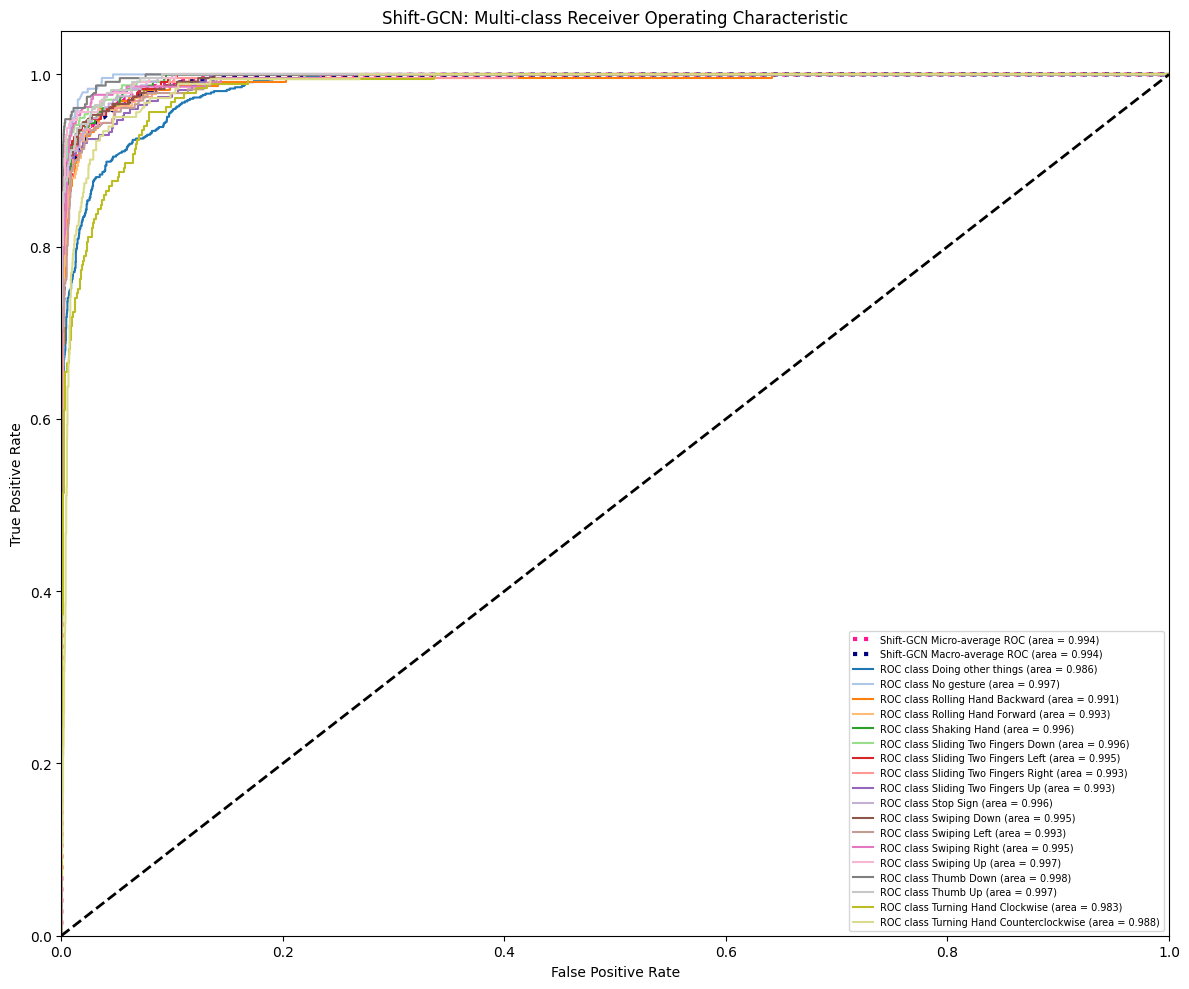

ROC curves plot saved to /kaggle/working/roc_curves_shiftgcn_detailed.png


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from itertools import cycle

if 'val_dataset' not in globals() or val_dataset is None:
    print("ERROR: 'val_dataset' is not defined or is None. Please load it first.")
elif 'model' not in globals() or model is None:
    print("ERROR: 'model' is not defined or is None. Please train or load it first.")
else:
    print("\n--- Evaluating Shift-GCN Model on Validation Dataset ---")

    # 1. Prepare data holders 
    y_true_strings_list = []         # For string labels 
    y_pred_strings_list = []         # For predicted string labels
    y_true_one_hot_list = []       # For one-hot encoded true labels
    y_pred_scores_list = []        # For softmax probability scores

    print("Gathering predictions and true labels from validation set...")
    for x_batch, y_batch_one_hot in tqdm(val_dataset):
        y_true_one_hot_list.append(y_batch_one_hot.numpy())

        batch_pred_scores = model.predict_on_batch(x_batch)
        y_pred_scores_list.append(batch_pred_scores)

        batch_true_indices = np.argmax(y_batch_one_hot.numpy(), axis=1)
        batch_pred_indices = np.argmax(batch_pred_scores, axis=1)

        for true_idx in batch_true_indices:
            y_true_strings_list.append(ACTIONS[true_idx])
        for pred_idx in batch_pred_indices:
            y_pred_strings_list.append(ACTIONS[pred_idx])

    final_y_true_strings = y_true_strings_list
    final_y_pred_strings = {"shift_gcn": y_pred_strings_list} 

    final_y_true_encoded = np.concatenate(y_true_one_hot_list, axis=0)
    final_y_pred_scores = {"shift_gcn": np.concatenate(y_pred_scores_list, axis=0)}

    print(f"\nShape of final_y_true_strings (list): ({len(final_y_true_strings)},)")
    print(f"Shape of final_y_pred_strings['shift_gcn'] (list): ({len(final_y_pred_strings['shift_gcn'])},)")
    print(f"Shape of final_y_true_encoded (numpy array): {final_y_true_encoded.shape}")
    print(f"Shape of final_y_pred_scores['shift_gcn'] (numpy array): {final_y_pred_scores['shift_gcn'].shape}")


    # 2. Compute Metrics 
    def compute_all_metrics(y_true_str_list, y_pred_str_dict, y_true_one_hot_array, y_scores_dict, actions_list):
        metrics_summary = {}
        for model_key in y_pred_str_dict.keys(): 
            current_y_pred_strings = y_pred_str_dict[model_key]
            current_y_scores = y_scores_dict[model_key]

            metrics_summary[model_key] = {
                "accuracy": accuracy_score(y_true_str_list, current_y_pred_strings),
                "precision": precision_score(y_true_str_list, current_y_pred_strings, average='weighted', zero_division=0, labels=actions_list),
                "recall": recall_score(y_true_str_list, current_y_pred_strings, average='weighted', zero_division=0, labels=actions_list),
                "f1": f1_score(y_true_str_list, current_y_pred_strings, average='weighted', zero_division=0, labels=actions_list),
                "auc": roc_auc_score(y_true_one_hot_array, current_y_scores, average='weighted', multi_class='ovr')
            }
        return metrics_summary

    print("\n--- Calculating Metrics for Shift-GCN Model ---")
    calculated_metrics = compute_all_metrics(
        final_y_true_strings,
        final_y_pred_strings,
        final_y_true_encoded,
        final_y_pred_scores,
        ACTIONS
    )

    # 3. Display and save results
    table_data = []
    for model_name_key, metric_values in calculated_metrics.items():
        display_model_name = "Shift-GCN" if model_name_key == "shift_gcn" else model_name_key.replace('_', ' ').title()
        table_data.append([
            display_model_name,
            metric_values['accuracy'],
            metric_values['precision'],
            metric_values['recall'],
            metric_values['f1'],
            metric_values['auc']
        ])

    df_results = pd.DataFrame(table_data, columns=[
        "Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"
    ])

    float_cols = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]
    for col in float_cols:
        df_results[col] = df_results[col].apply(lambda x: f"{x:.4f}")

    print("\n--- Evaluation Results ---")
    print(df_results.to_string(index=False))
    df_results.to_csv("/kaggle/working/shift_gcn_evaluation_results.csv", index=False)
    print("\nEvaluation results saved to /kaggle/working/shift_gcn_evaluation_results.csv")

    # 4. Detailed classification Report
    print("\n--- Detailed Classification Report (Shift-GCN) ---")
    report = classification_report(final_y_true_strings,
                                   final_y_pred_strings['shift_gcn'],
                                   target_names=ACTIONS,
                                   zero_division=0)
    print(report)
    with open("/kaggle/working/classification_report_shiftgcn_detailed.txt", "w") as f:
        f.write(report)
    print("Detailed classification report saved to /kaggle/working/classification_report_shiftgcn_detailed.txt")


    # 5. ROC Curve Plotting 
    print("\n--- Plotting ROC Curves (Shift-GCN) ---")
    fpr = dict()
    tpr = dict()
    roc_auc_per_class = dict()
    n_classes = NUM_CLASSES
    
    current_model_scores = final_y_pred_scores['shift_gcn']

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(final_y_true_encoded[:, i], current_model_scores[:, i])
        roc_auc_per_class[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(final_y_true_encoded.ravel(), current_model_scores.ravel())
    roc_auc_per_class["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc_per_class["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(12, 10))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Shift-GCN Micro-average ROC (area = {roc_auc_per_class["micro"]:0.3f})',
             color='deeppink', linestyle=':', linewidth=3)
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'Shift-GCN Macro-average ROC (area = {roc_auc_per_class["macro"]:0.3f})',
             color='navy', linestyle=':', linewidth=3)

    colors = cycle(plt.cm.get_cmap('tab20').colors) 
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
                 label=f'ROC class {ACTIONS[i]} (area = {roc_auc_per_class[i]:0.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Shift-GCN: Multi-class Receiver Operating Characteristic')
    plt.legend(loc="lower right", prop={'size': 7}) 
    plt.tight_layout()
    plt.savefig("/kaggle/working/roc_curves_shiftgcn_detailed.png")
    plt.show()
    print("ROC curves plot saved to /kaggle/working/roc_curves_shiftgcn_detailed.png")